---
title: "Automatic Number Plate Recognition"
author: "[GeekyRakshit](../)"
date: "2020-04-13"
categories: [computervision, deeplearning, keras, python, tensorflow]
description: Automatic Number Plate Recognition in Hangul using Convolutional Recurrent Neural Network
image: "./assets/anpr.png"
freeze: true
execute:
  warning: false
---

**Project Repository:** [https://github.com/soumik12345/Automatic-Number-Plate-Recognition](https://github.com/soumik12345/Automatic-Number-Plate-Recognition)

## Generating Training Data

In [2]:
#collapse-hide
import os

print('Generating Training Data\n')

os.chdir('./Korean-license-plate-Generator')

!mkdir ../Train_Images

print('Augmentated Images Generating...\n')
!python ./Generator_augmentation.py --img_dir "../Train_Images/" --num 10000 --save True
print('Augmentated Images Generated\n')

print('Original Images Generating...\n')
!python ./Generator_original.py --img_dir "../Train_Images/" --num 10000 --save True
print('Original Images Generated\n')

print('Perspective Images Generating...\n')
!python ./Generator_perspective.py --img_dir "../Train_Images/" --num 10000 --save True
print('Perspective Images Generated\n')

os.chdir('../')

print('Done.')

Generating Training Data

Augmentated Images Generating...

Type 1 finish
Type 2 finish
Type 3 finish
Type 4 finish
Type 5 finish
Augmentated Images Generated

Original Images Generating...

Type 1 finish
Type 2 finish
Type 3 finish
Type 4 finish
Type 5 finish
Original Images Generated

Perspective Images Generating...

Type 1 finish
Type 2 finish
Type 3 finish
Type 4 finish
Type 5 finish
Perspective Images Generated

Done.


## Generating Validation Data

In [3]:
#collapse-hide
print('Generating Validation Data\n')

os.chdir('./Korean-license-plate-Generator')

!mkdir ../Validation_Images

print('Augmentated Images Generating...\n')
!python ./Generator_augmentation.py --img_dir "../Validation_Images/" --num 1000 --save True
print('Augmentated Images Generated\n')

print('Original Images Generating...\n')
!python ./Generator_original.py --img_dir "../Validation_Images/" --num 1000 --save True
print('Original Images Generated\n')

print('Perspective Images Generating...\n')
!python ./Generator_perspective.py --img_dir "../Validation_Images/" --num 1000 --save True
print('Perspective Images Generated\n')

os.chdir('../')

print('Done.')

Generating Validation Data

Augmentated Images Generating...

Type 1 finish
Type 2 finish
Type 3 finish
Type 4 finish
Type 5 finish
Augmentated Images Generated

Original Images Generating...

Type 1 finish
Type 2 finish
Type 3 finish
Type 4 finish
Type 5 finish
Original Images Generated

Perspective Images Generating...

Type 1 finish
Type 2 finish
Type 3 finish
Type 4 finish
Type 5 finish
Perspective Images Generated

Done.


## Importing Libraries

In [1]:
#collapse-hide
import cv2
import itertools
import os, random
import numpy as np
from glob import glob
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt

from keras import backend as K
from keras.layers import (
    Conv2D, MaxPooling2D,
    Input, Dense, Activation,
    Reshape, Lambda,
    BatchNormalization, CuDNNLSTM
)
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.optimizers import Adadelta
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model, Sequence

Using TensorFlow backend.


## Configs

In [2]:
CHAR_VECTOR = "adefghjknqrstwABCDEFGHIJKLMNOPZ0123456789"

letters = [letter for letter in CHAR_VECTOR]

num_classes = len(letters) + 1

img_w, img_h = 128, 64

# Network parameters
batch_size = 128
val_batch_size = 16

downsample_factor = 4
max_text_len = 9

K.set_learning_phase(0)

## Data Generation

In [ ]:
def labels_to_text(labels):
    return ''.join(list(map(lambda x: letters[int(x)], labels)))

def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

In [ ]:
class DataGenerator(Sequence):

    def __init__(self, image_path, batch_size, image_width, image_height, downsample_factor, shuffle = True, max_text_len = 9):
        '''Datagenerator'''
        self.image_path = image_path
        self.image_list = glob(self.image_path + '/*')
        self.batch_size = batch_size
        self.image_width = image_width
        self.image_height = image_height
        self.downsample_factor = downsample_factor
        self.shuffle = shuffle
        self.max_text_len = max_text_len
        self.on_epoch_end()
    
    def __len__(self):
        '''Denotes the number of batches per epoch'''
        return int(np.floor(len(self.image_list) / self.batch_size))
    
    def __getitem__(self, index):
        '''Generate Single Batch of Data'''
        
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.image_list[k] for k in indexes]

        # Generate data
        inputs, outputs = self.__data_generation(list_IDs_temp)

        return inputs, outputs
    
    def on_epoch_end(self):
        '''Updates indexes after each epoch'''
        self.indexes = np.arange(len(self.image_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, list_IDs_temp):
        '''Generates data containing batch_size samples'''
        
        # Reading Data
        images = []
        texts = []
        label_length = np.zeros((self.batch_size, 1))
        
        for i, img_file in enumerate(list_IDs_temp):
            image = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (self.image_width, self.image_height))
            image = image.astype(np.float32)
            image = (image / 255.0)
            images.append(image.T)
            text = img_file[0 : -4].split('/')[-1]
            texts.append(text_to_labels(text))
            label_length[i] = len(text)
            # images[i, :, :] = image
        
        input_length = np.ones((self.batch_size, 1)) * (self.image_width // self.downsample_factor - 2)
        images = np.expand_dims(np.array(images), axis = 3)
        
        inputs = {
            'the_input': images,  # (bs, 128, 64, 1)
            'the_labels': np.array(texts),  # (bs, 8)
            'input_length': input_length,  # (bs, 1) 
            'label_length': np.array(label_length)  # (bs, 1)
        }

        outputs = {'ctc': np.zeros([self.batch_size])} # (bs, 1) 

        return (inputs, outputs)

In [ ]:
datagen = DataGenerator('./Train_Images', batch_size, 128, 64, 4, True, 9)

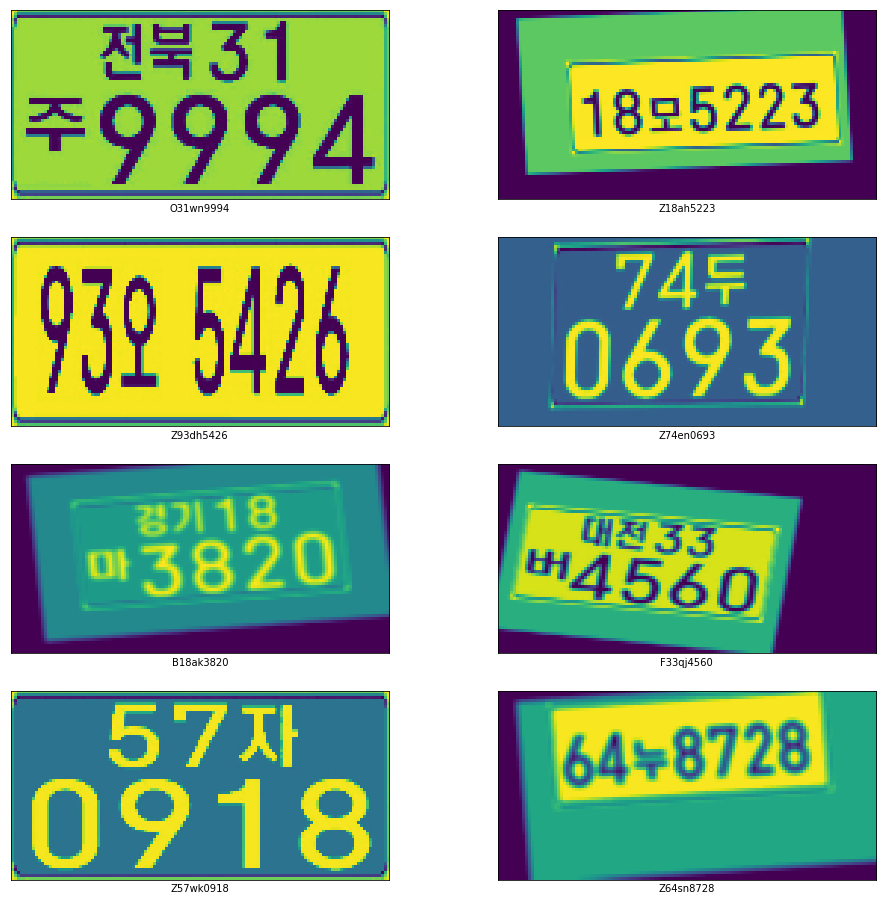

In [6]:
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (16, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
inp, out = datagen.__getitem__(0)
c = 1
for i, ax in enumerate(axes.flat):
    ax.imshow(inp['the_input'][c].reshape(img_w, img_h).T)
    ax.set_xlabel(labels_to_text(inp['the_labels'][c]))
    c += 1
plt.show()

## Network Architecture

In [ ]:
# # Loss and train functions, network architecture
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [ ]:
def get_Model(training):
    input_shape = (img_w, img_h, 1)     # (128, 64, 1)

    # Make Networkw
    inputs = Input(name='the_input', shape=input_shape, dtype='float32')  # (None, 128, 64, 1)

    # Convolution layer (VGG)
    inner = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(inputs)  # (None, 128, 64, 64)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)  # (None,64, 32, 64)

    inner = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)  # (None, 64, 32, 128)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)  # (None, 32, 16, 128)

    inner = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)  # (None, 32, 16, 256)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(inner)  # (None, 32, 16, 256)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)  # (None, 32, 8, 256)

    inner = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(inner)  # (None, 32, 8, 512)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = Conv2D(512, (3, 3), padding='same', name='conv6')(inner)  # (None, 32, 8, 512)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(1, 2), name='max4')(inner)  # (None, 32, 4, 512)

    inner = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(inner)  # (None, 32, 4, 512)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)

    # CNN to RNN
    inner = Reshape(target_shape=((32, 2048)), name='reshape')(inner)  # (None, 32, 2048)
    inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)  # (None, 32, 64)

    # RNN layer
    lstm_1 = CuDNNLSTM(256, return_sequences=True, kernel_initializer='he_normal', name='lstm1')(inner)  # (None, 32, 512)
    lstm_1b = CuDNNLSTM(256, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='lstm1_b')(inner)
    lstm1_merged = add([lstm_1, lstm_1b])  # (None, 32, 512)
    lstm1_merged = BatchNormalization()(lstm1_merged)
    lstm_2 = CuDNNLSTM(256, return_sequences=True, kernel_initializer='he_normal', name='lstm2')(lstm1_merged)
    lstm_2b = CuDNNLSTM(256, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='lstm2_b')(lstm1_merged)
    lstm2_merged = concatenate([lstm_2, lstm_2b])  # (None, 32, 1024)
    lstm_merged = BatchNormalization()(lstm2_merged)

    # transforms RNN output to character activations:
    inner = Dense(num_classes, kernel_initializer='he_normal',name='dense2')(lstm2_merged) #(None, 32, 63)
    y_pred = Activation('softmax', name='softmax')(inner)

    labels = Input(name='the_labels', shape=[max_text_len], dtype='float32') # (None ,8)
    input_length = Input(name='input_length', shape=[1], dtype='int64')     # (None, 1)
    label_length = Input(name='label_length', shape=[1], dtype='int64')     # (None, 1)

    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length]) #(None, 1)

    if training:
        return Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)
    else:
        return Model(inputs=[inputs], outputs=y_pred)

In [13]:
model = get_Model(training = True)
model.summary()







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 128, 64, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 64, 64)  640         the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 64, 64)  256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 64, 64)  0           batch_normalization_1[0][0

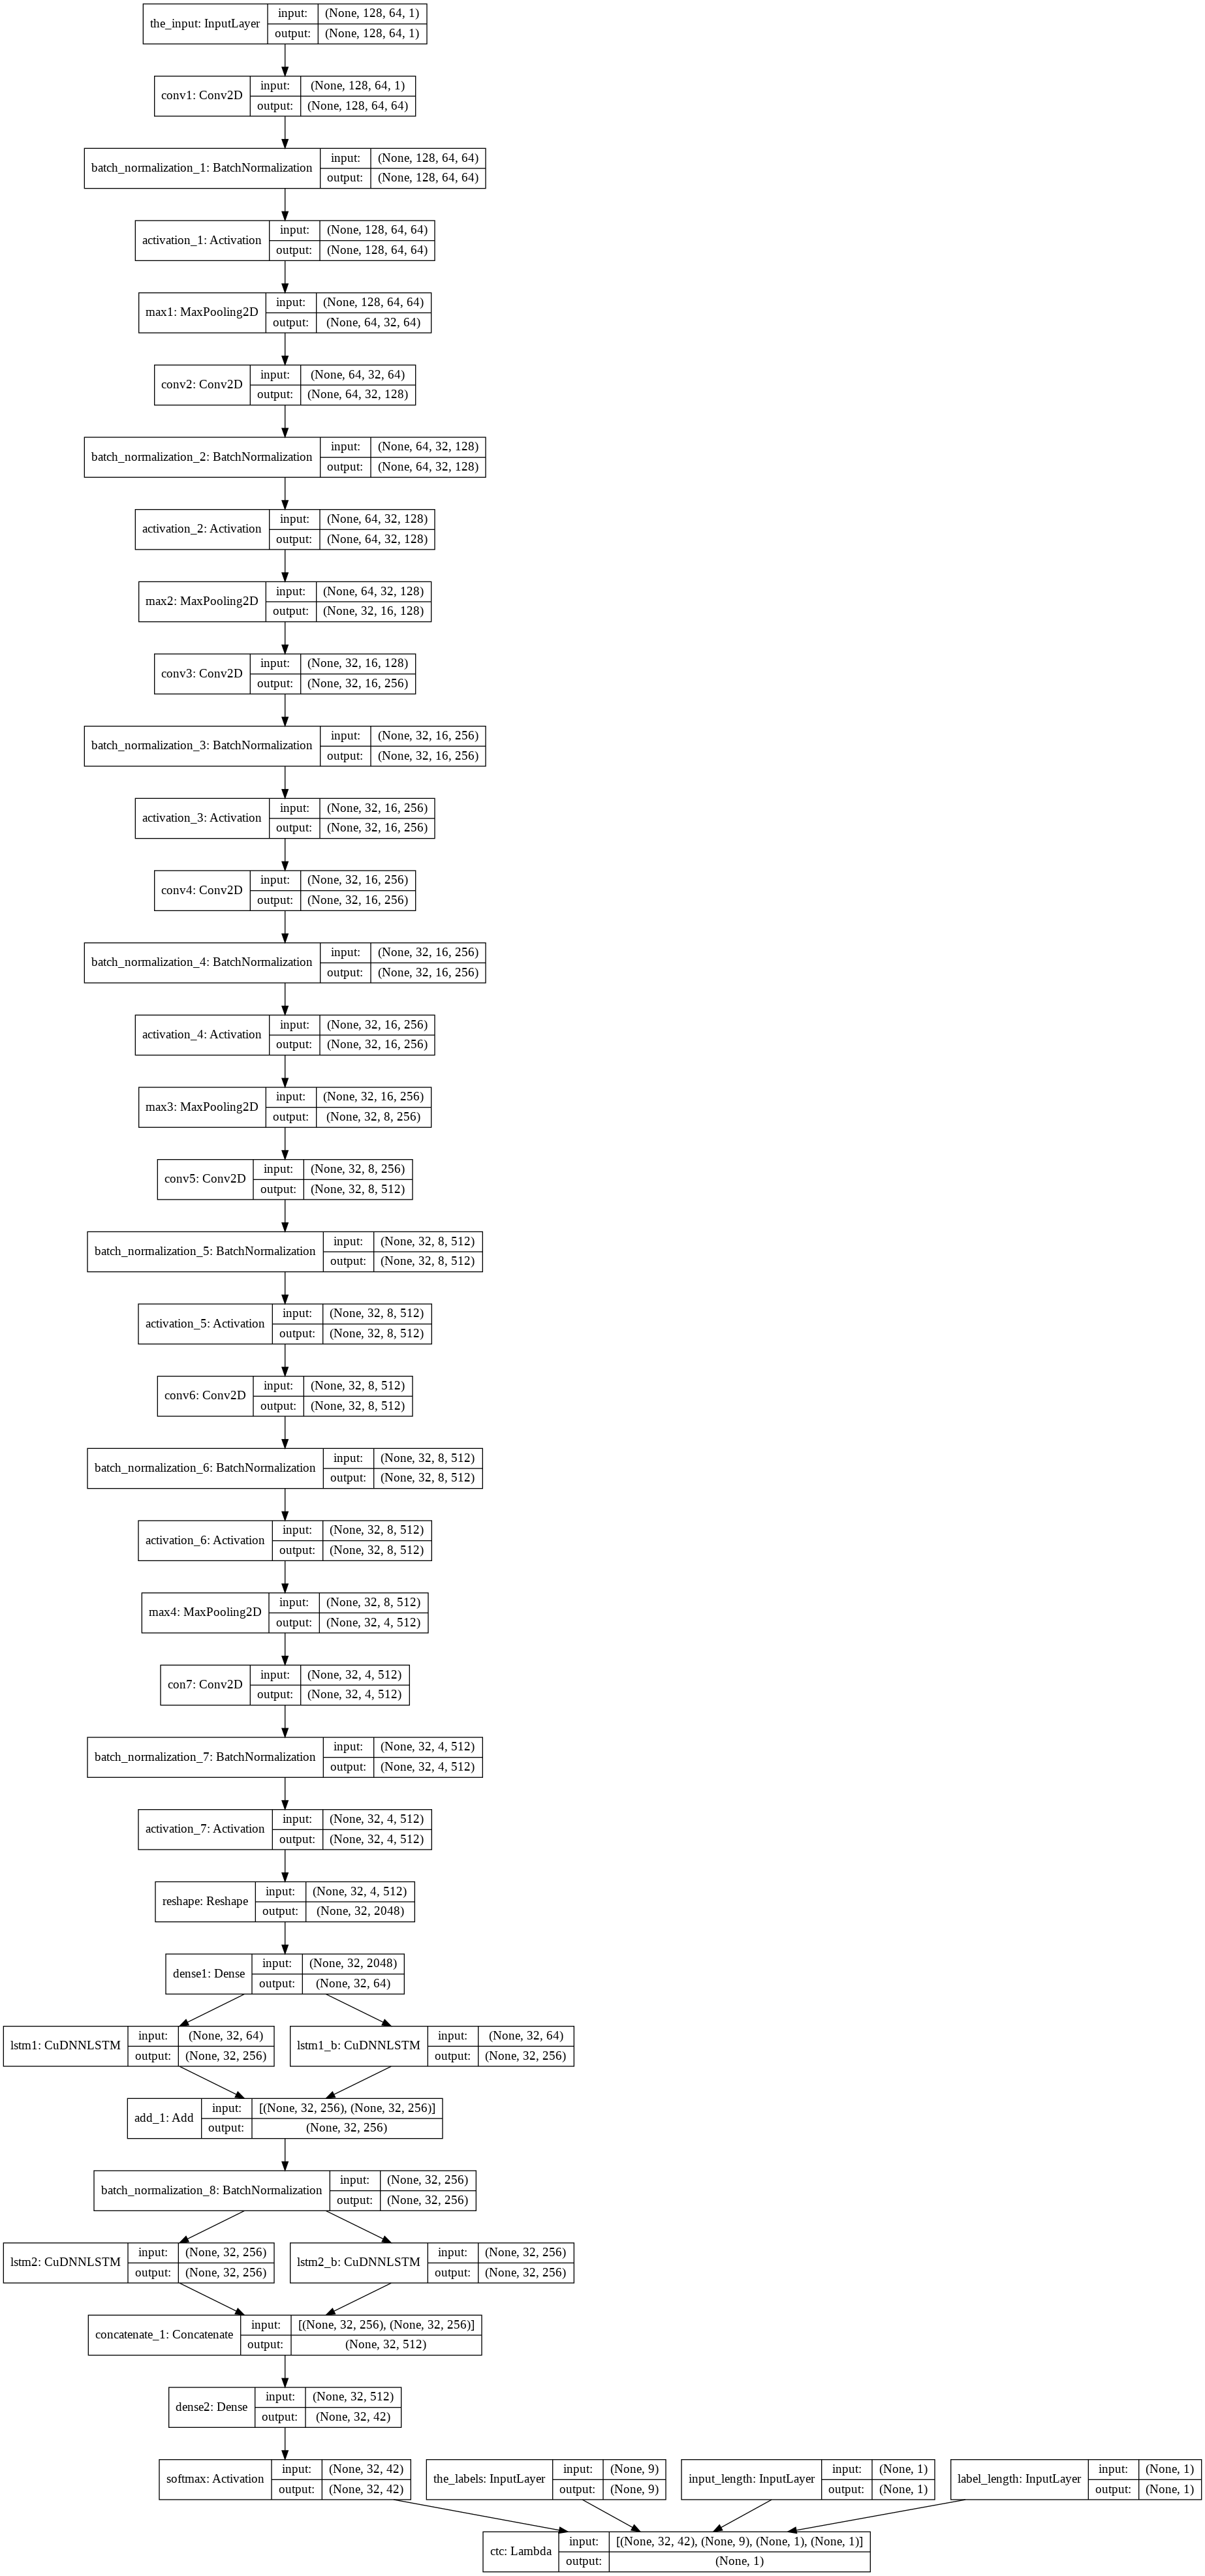

In [14]:
plot_model(
    model,
    to_file = 'model.png',
    show_shapes = True,
    show_layer_names = True,
    rankdir = 'TB'
)

## Training Model

In [15]:
model.compile(loss = {'ctc': lambda y_true, y_pred: y_pred}, optimizer = Adadelta())

In [ ]:
train_datagen = DataGenerator('./Train_Images', batch_size, img_w, img_h, downsample_factor, True, max_text_len)
valid_datagen = DataGenerator('./Validation_Images', batch_size, img_w, img_h, downsample_factor, True, max_text_len)

In [ ]:
early_stop = EarlyStopping(
    monitor = 'val_loss', min_delta = 0.001,
    patience = 4, mode = 'min',
    verbose = 1
)

checkpoint = ModelCheckpoint(
    filepath = 'CuDNNLSTM+BN5--{epoch:02d}--{loss:.3f}--{val_loss:.3f}.hdf5',
    monitor = 'val_loss', verbose = 1,
    mode = 'min', period = 1
)

In [18]:
history = model.fit_generator(
    generator = train_datagen,
    steps_per_epoch = int(len(train_datagen.image_list) // batch_size),
    epochs = 30, callbacks = [checkpoint],
    validation_data = valid_datagen,
    validation_steps = int(len(valid_datagen.image_list) // batch_size)
)

Epoch 1/30
1171/1171 [==============================] - 812s 693ms/step - loss: 23.8972 - val_loss: 20.9087

Epoch 00001: saving model to CuDNNLSTM+BN5--01--23.897--20.909.hdf5
Epoch 2/30
1171/1171 [==============================] - 789s 674ms/step - loss: 21.5477 - val_loss: 22.0248

Epoch 00002: saving model to CuDNNLSTM+BN5--02--21.548--22.025.hdf5
Epoch 3/30
1171/1171 [==============================] - 790s 675ms/step - loss: 21.1628 - val_loss: 21.1927

Epoch 00003: saving model to CuDNNLSTM+BN5--03--21.163--21.193.hdf5
Epoch 4/30
1171/1171 [==============================] - 789s 673ms/step - loss: 21.3286 - val_loss: 20.7860

Epoch 00004: saving model to CuDNNLSTM+BN5--04--21.329--20.786.hdf5
Epoch 5/30
1171/1171 [==============================] - 797s 681ms/step - loss: 20.6932 - val_loss: 20.4295

Epoch 00005: saving model to CuDNNLSTM+BN5--05--20.693--20.430.hdf5
Epoch 6/30
1171/1171 [==============================] - 803s 686ms/step - loss: 19.6645 - val_loss: 18.8030

Epoch 

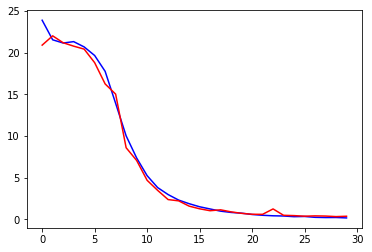

In [19]:
plt.plot(history.history['loss'], color = 'b')
plt.plot(history.history['val_loss'], color = 'r')
plt.show()

In [ ]:
Region = {"A": "서울 ", "B": "경기 ", "C": "인천 ", "D": "강원 ", "E": "충남 ", "F": "대전 ",
          "G": "충북 ", "H": "부산 ", "I": "울산 ", "J": "대구 ", "K": "경북 ", "L": "경남 ",
          "M": "전남 ", "N": "광주 ", "O": "전북 ", "P": "제주 "}
Hangul = {"dk": "아", "dj": "어", "dh": "오", "dn": "우", "qk": "바", "qj": "버", "qh": "보", "qn": "부",
          "ek": "다", "ej": "더", "eh": "도", "en": "두", "rk": "가", "rj": "거", "rh": "고", "rn": "구",
          "wk": "자", "wj": "저", "wh": "조", "wn": "주", "ak": "마", "aj": "머", "ah": "모", "an": "무",
          "sk": "나", "sj": "너", "sh": "노", "sn": "누", "fk": "라", "fj": "러", "fh": "로", "fn": "루",
          "tk": "사", "tj": "서", "th": "소", "tn": "수", "gj": "허"}

In [ ]:
def decode_label(out):
    # out : (1, 32, 42)
    out_best = list(np.argmax(out[0, 2:], axis=1))  # get max index -> len = 32
    out_best = [k for k, g in itertools.groupby(out_best)]  # remove overlap value
    outstr = ''
    for i in out_best:
        if i < len(letters):
            outstr += letters[i]
    return outstr

In [ ]:
def label_to_hangul(label):  # eng -> hangul
    region = label[0]
    two_num = label[1:3]
    hangul = label[3:5]
    four_num = label[5:]

    try:
        region = Region[region] if region != 'Z' else ''
    except:
        pass
    try:
        hangul = Hangul[hangul]
    except:
        pass
    return region + two_num + hangul + four_num

In [12]:
model = get_Model(training = False)
model.load_weights('CuDNNLSTM+BN5--29--0.211--0.319.hdf5')







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
inp, out = valid_datagen.__getitem__(0)
images = inp['the_input']
images.shape

(128, 128, 64, 1)

In [16]:
predictions = model.predict(images[0].reshape(1, img_w, img_h, 1), verbose = 1)
predictions.shape


1/1 [==============================] - 2s 2s/step


(1, 32, 42)

In [17]:
pred_texts = decode_label(predictions)
pred_texts

'Z16th6435'

Text(0.5, 1.0, 'Z16th6435')

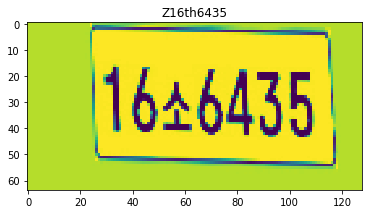

In [20]:
plt.imshow(images[0].reshape(img_w, img_h).T)
plt.title(pred_texts)

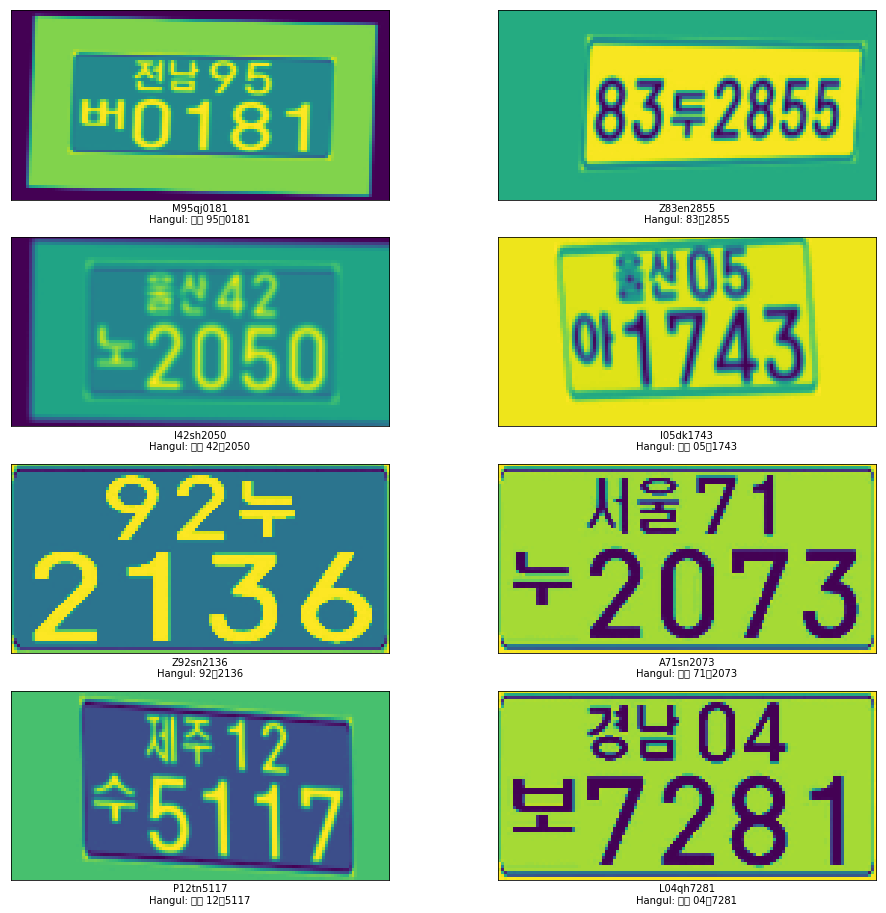

In [23]:
#collapse-hide
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (16, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
c = 1
for i, ax in enumerate(axes.flat):
    image = inp['the_input'][c].reshape(1, img_w, img_h, 1)
    prediction = model.predict(image)
    ax.imshow(image.reshape(img_w, img_h).T)
    ax.set_xlabel(decode_label(prediction) + '\n' + 'Hangul: ' + label_to_hangul(decode_label(prediction)))
    c += 1
plt.show()